# Projeto de BI em PySpark

# Arquitetura Cloud (AWS)

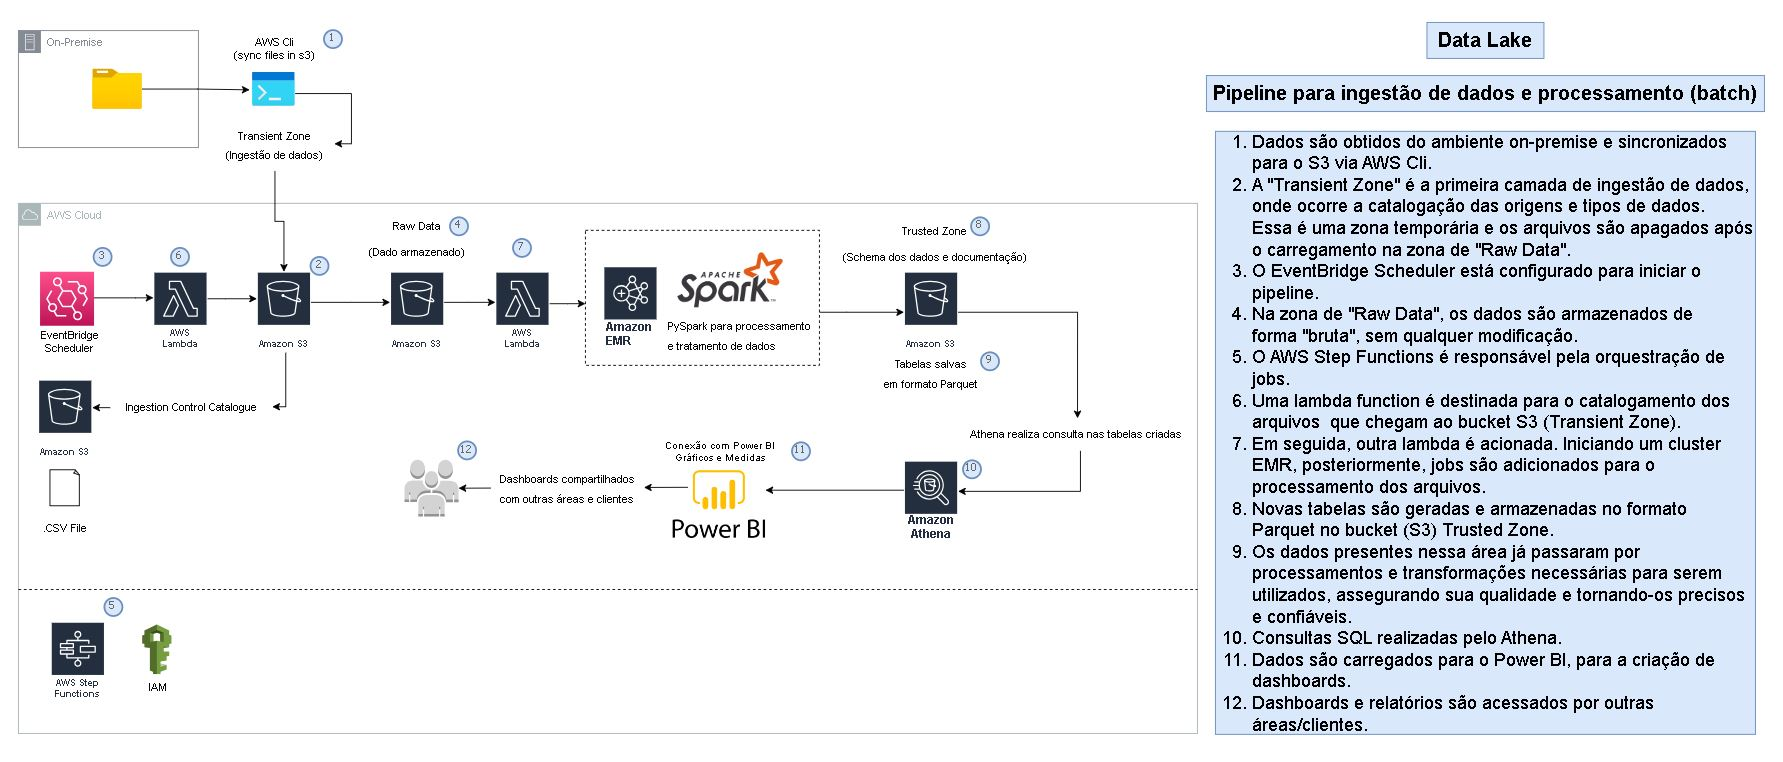


# Armazenamento em um novo bucket S3 (Refined Zone - formato Parquet)

# Diagrama 

Conforme o diagrama proposto, este projeto utilizará 3 tabelas
*   1 tabela fato - Todos os registros de músicas escutadas por usuário
*   1 tabela dimensão - Todos os usuários
*   1 tabela dimensão - Todas as musicas/artista


Diagrama feito no Draw.io

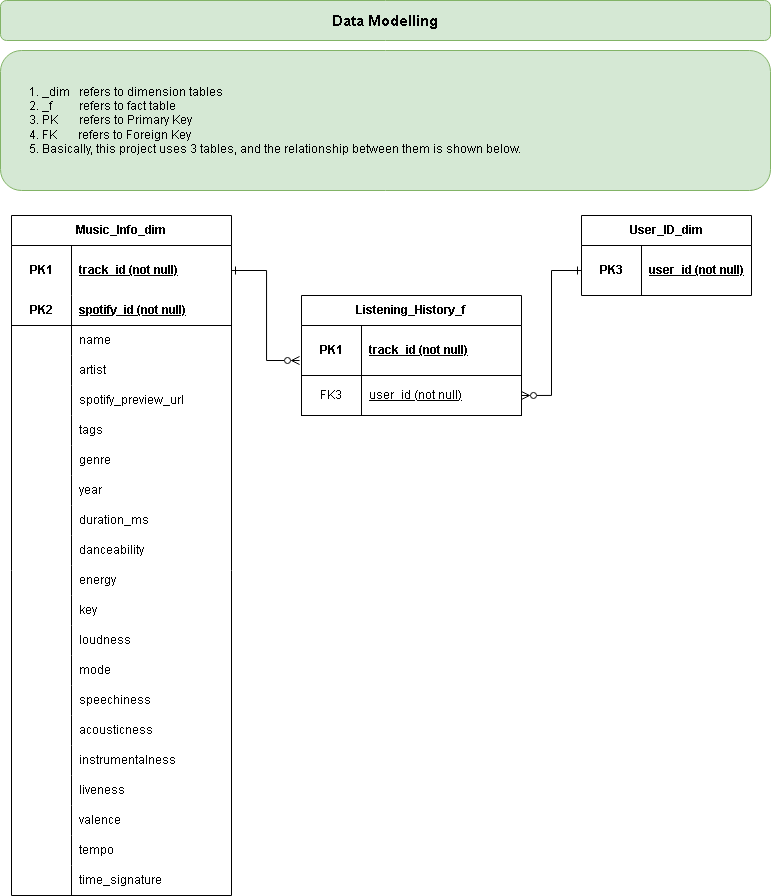

# Dashboard desenvolvido para a área de BI

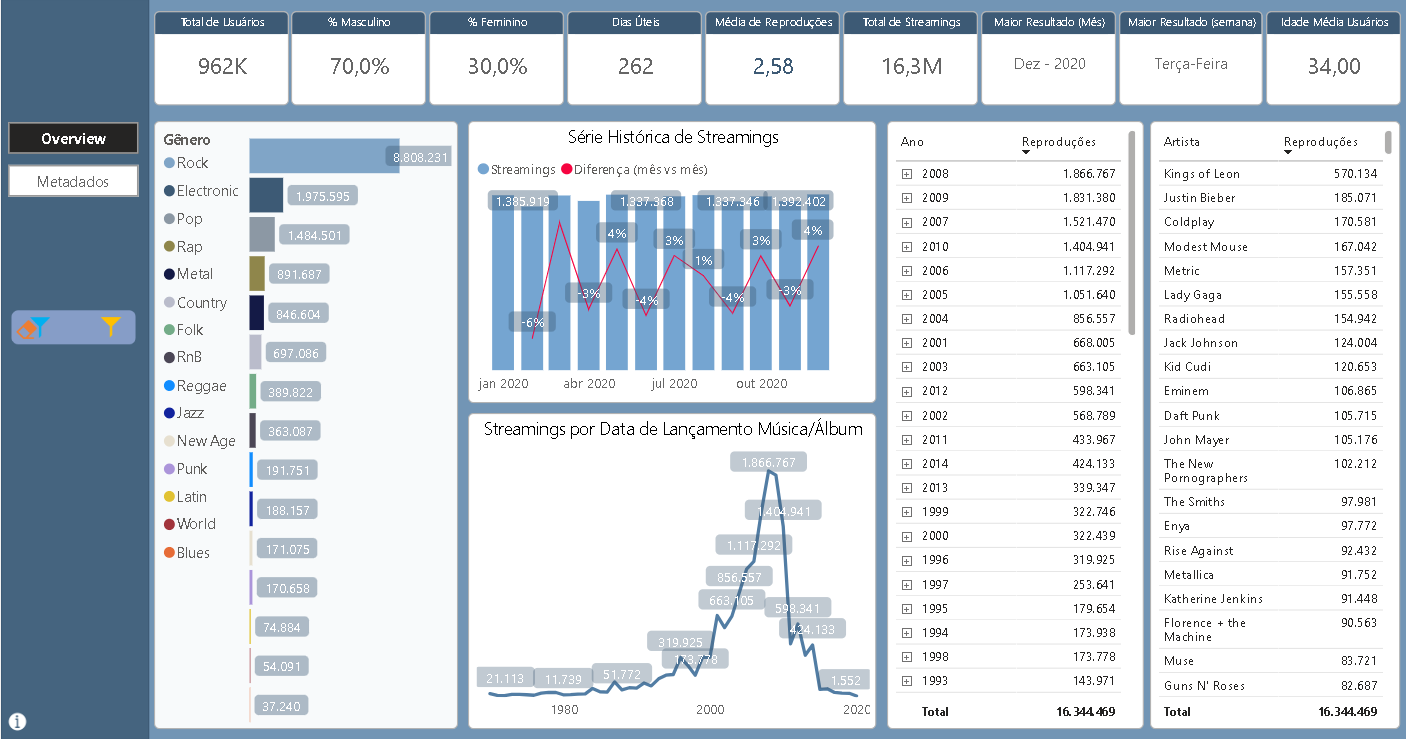

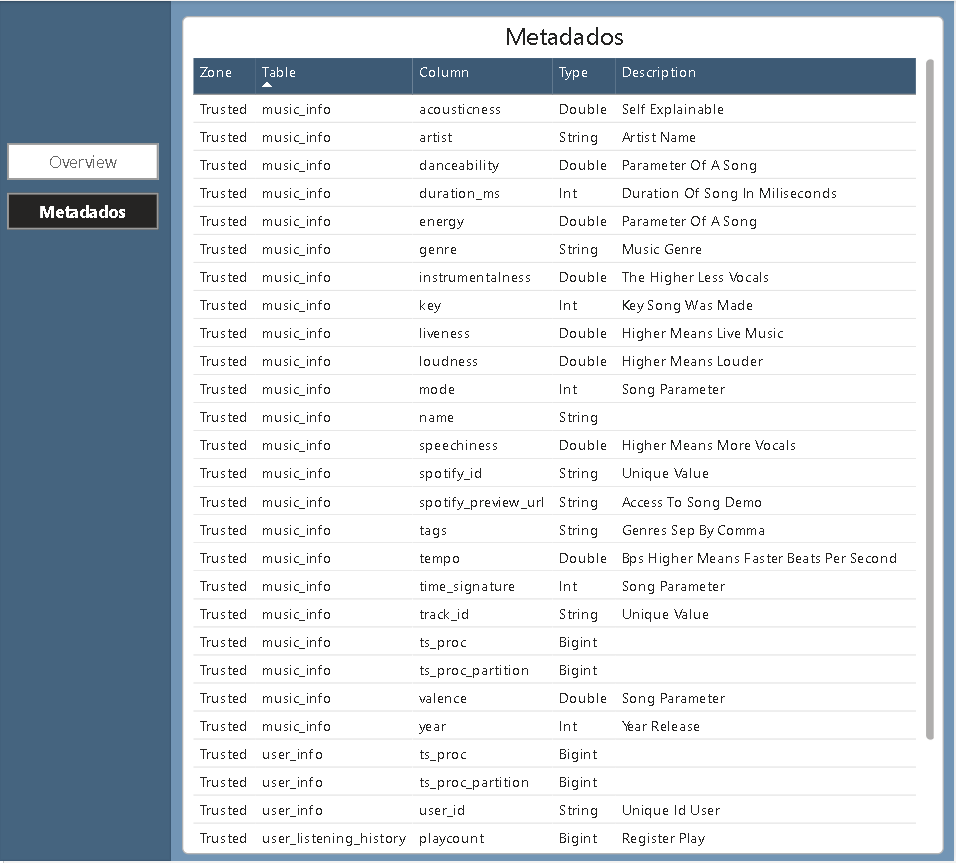

# Principais Pontos do Dashboard:

- Conexão realizada via Athena
- Dados históricos de streaming para o ano de 2020
- Ideia principal:
    - Apresentar o comportamento de streamings ao longo do ano de 2020, mapeando o principal gênero dos usuários.
    - Quais artistas, álbuns e data de lançamento de discos e singles apresentaram maiores resultados.
    - Fornecer um dashboard para entendimento macro das informações históricas, e futuramente desenvolver estudos específicos, de acordo com a necessidade da empresa.
    
O arquivo PBIX para edição do dashboard está diponível no GitHub.

# Principais Pontos do README
Análise exploratória para verificar inconsistências e erros prensentes nas tabelas.
Os códigos para automação estão separados em pastas no github para o Data Lake:
- Scripts para lambda functions
- Scripts para leitura de dados por camadas (transient, raw, trusted)
- Script para Metadados (Data Lineage)

# Arquivos sincronizados de um desktop e salvos em um bucket (S3) no formato .csv 

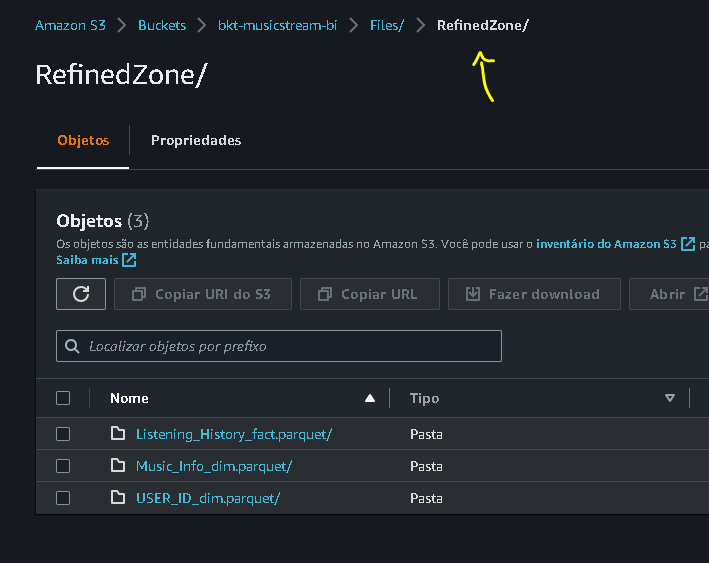

# Tabelas Criadas

# AWS CLI Commands (Powershell) 

## Enviar arquivos para Transient Zone (camada de ingestão de dados)

###### Listar Buckets

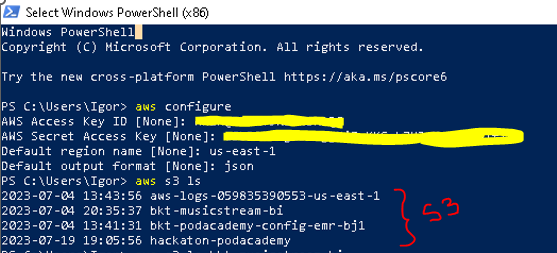

#####  Listar arquivos no bucket Transient Zone

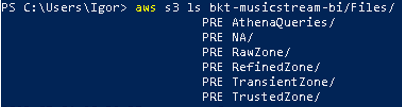

#####  Enviar arquivos para o bucket Transient Zone

# Processos do Notebook

#### Iniciar sessão Spark

In [51]:
#!/usr/bin/env python
# coding: utf-8

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [53]:
import os
import sys
import pytz
import numpy as np
import datetime
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, udf, lpad, translate
from datetime import datetime 
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
from pyspark.sql.types import *
from pyspark.sql.functions import count, avg

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
agora = datetime.now(pytz.timezone('America/Sao_Paulo'))
dthproc = agora.strftime("%Y%m%d%H%M%S")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
spark = SparkSession.builder.appName("t_Music_Info").getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
file = "Music_Info.csv"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
ts_file_generation = file.split("-")[-1].replace(".csv", "") + "00"
print(ts_file_generation)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Music_Info00

In [19]:
bucket_raw = "bkt-musicstream-bi/Files/RawZone"
bucket_ingestion = "bkt-musicstream-bi/Files/TransientZone"
bucket_control = "bkt-musicstream-bi/Files/Control"
bucket_trusted = "bkt-musicstream-bi/Files/NA/NATrusted"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
output_lake = "Music_Catalog"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
full_path_ingestion = "s3://{bkt}/{file}".format(bkt=bucket_ingestion, file=file)
print(full_path_ingestion)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://bkt-musicstream-bi/Files/TransientZone/Music_Info.csv

In [22]:
#music_info_t = spark.read.csv(full_path_ingestion, sep=",", header=True).

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
pouso = spark.read.format(
    "com.databricks.spark.csv").option(
    "header", "true").option(
    "enconding", "ISO-8859-1").option(
    "enconding", "UTF-8").option(
    "inferSchema", "false").option(
    "delimiter", ",").load(
    full_path_ingestion)
pouso.registerTempTable("pouso")
pouso.cache()
qtd=pouso.count() 
print('registros ingestao de dados:', qtd)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

registros ingestao de dados: 50683

##### Listando Colunas

In [24]:
for col in pouso.columns:
    print(col + ",")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

track_id,
name,
artist,
spotify_preview_url,
spotify_id,
tags,
genre,
year,
duration_ms,
danceability,
energy,
key,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
time_signature,

O particionamento da tabela lake foi feito pensado no consumo do dado, ou seja, faz mais sentido que a informação seja consumida e armazenada por data de lançamento do álbum.

In [38]:
lake = spark.sql(
    """ 
        select
            -- padrao para todas as tabelas
            
            --int(date_format(created_at, 'yyyyMMMM')) as ref,
            --int(date_format(created_at, 'yyyyMMMM')) as ref_partition,
            
            --{tsfileger} as ts_file_generation,
            --{tsfileger} as ts_file_generation_partition,
            
            {pdthproc} as ts_proc,
            {pdthproc} as ts_proc_partition,
            
            year as ref_year,
            year as ref_year_partition,
            
            -- campos do arquivos
            
            track_id,
            name,
            artist,
            spotify_preview_url,
            spotify_id,
            tags,
            genre,
            year,
            duration_ms,
            danceability,
            energy,
            key,
            loudness,
            mode,
            speechiness,
            acousticness,
            instrumentalness,
            liveness,
            valence,
            tempo,
            time_signature
            
        from
            pouso
    
    """.format(tsfileger=ts_file_generation, pdthproc=dthproc))
lake.registerTempTable("lake")
lake.cache()
lake.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

50683

In [39]:
lake.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['ts_proc', 'ts_proc_partition', 'ref_year', 'ref_year_partition', 'track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id', 'tags', 'genre', 'year', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

In [40]:
print("s3://bkt-musicstream-bi/Files/RawZone/Music_Catalog/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://bkt-musicstream-bi/Files/RawZone/Music_Catalog/

In [41]:
path_raw = os.path.join('s3://', bucket_raw, output_lake)
print(path_raw)

lake.coalesce(1).write. \
partitionBy("ref_year_partition"). \
parquet(path_raw, mode='overwrite')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://bkt-musicstream-bi/Files/RawZone/Music_Catalog

In [42]:
varDataFile = output_lake

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
controle = spark.sql(
        """
            select 
                '{tb}' as name_file,
                '{tb}' as name_file_partition,
                
                --ref,
                --ref_partition,
                
                ts_proc,
                ts_proc_partition,
                
                count(*) as qtd_registros
            
            from
                lake as a
            group by
                1, 2, 3, 4
            order by
                1, 2, 3, 4
        """.format(tb=varDataFile))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
controle.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------------+--------------+-----------------+-------------+
|    name_file|name_file_partition|       ts_proc|ts_proc_partition|qtd_registros|
+-------------+-------------------+--------------+-----------------+-------------+
|Music_Catalog|      Music_Catalog|20230726205238|   20230726205238|        50683|
+-------------+-------------------+--------------+-----------------+-------------+

In [46]:
controle.registerTempTable("controle")
controle.cache()
qtd = controle.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
controle.show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------------+--------------+-----------------+-------------+
|name_file    |name_file_partition|ts_proc       |ts_proc_partition|qtd_registros|
+-------------+-------------------+--------------+-----------------+-------------+
|Music_Catalog|Music_Catalog      |20230726205238|20230726205238   |50683        |
+-------------+-------------------+--------------+-----------------+-------------+

In [108]:
path_control = os.path.join("s3://", bucket_control, "tb_0001_controle_processamento_raw")
print(path_control)
controle.coalesce(1).write. \
parquet(path_control, mode="append")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://bkt-musicstream-bi/Files/Control/tb_0001_controle_processamento_raw

# Preparação Dados

# S3 Datasets

In [9]:
music_info_raw = spark.read.csv("s3://bkt-musicstream-bi/Files/RawZone/Music_Info.csv", sep=",", header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
user_listening_history_raw = spark.read.csv("s3://bkt-musicstream-bi/Files/RawZone/User_Listening_History.csv", sep=",", header=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Num Linhas/Colunas (Shape)

In [15]:
#numero colunas e linhas
num_rows = music_info_raw.count()
num_cols = len(music_info_raw.columns)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
print('Shape: ({}, {})'.format(num_rows, num_cols))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Shape: (50683, 21)

In [17]:
#numero colunas e linhas
num_rows1 = user_listening_history_raw.count()
num_cols1 = len(user_listening_history_raw.columns)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
print('Shape: ({}, {})'.format(num_rows1, num_cols1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Shape: (9711301, 3)

# Desc Colunas (Columns description)

In [19]:
#colunas
music_info_raw.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id', 'tags', 'genre', 'year', 'duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

In [20]:
#colunas
user_listening_history_raw.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['track_id', 'user_id', 'playcount']

# Schema

In [21]:
#Schema Tabela
#Podemos notar que todos os dados foram armazenados como string, faremos alteracoes futuramente para melhor performance
user_listening_history_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: string (nullable = true)

In [22]:
#Schema Tabela
#Podemos notar que todos os dados foram armazenados como string, faremos alteracoes futuramente para melhor performance
music_info_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- spotify_preview_url: string (nullable = true)
 |-- spotify_id: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)

# Carregue o arquivo com inferência automática de tipos e cabeçalho
xd = spark.read.options(inferSchema="true", header="true").csv("s3://bkt-musicstream-bi/Files/RawZone/Music_Info.csv", sep=",")

# Exiba o esquema inferido
xd.printSchema()

# Verificando a existência de registros nulos

### Criando uma funcao (creating a function)

In [23]:
def check_nulls(dataframe, name) -> None:
    '''
    Verifica e exibe a quantidade de valores nulos em cada coluna do dataframe.

    :param dataframe: DataFrame
        Dataframe a ser analisado.
    :param name: str
        Nome identificando o dataframe para exibição na saída.
    '''
    print(f'\n{name.upper()} { "-" * (100 - len(name))}')
    for coluna in dataframe.columns:
        qty = dataframe.filter(dataframe[coluna].isNull()).count()
        if qty >= 1:
            print(f'{coluna}: {qty}')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Aplicando a funcao

In [24]:
#Utilizando a def
check_nulls(user_listening_history_raw, "listening_history")
check_nulls(music_info_raw,"music_info")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…


LISTENING_HISTORY -----------------------------------------------------------------------------------

MUSIC_INFO ------------------------------------------------------------------------------------------
tags: 1127
genre: 28335

In [25]:
#Podemos verificar que o historico de musicas nao apresenta nenhum valor nulo, por se tratar de uma tabela fato
#Verificaremos posteriormente se todos os itens da Fato estao presentes nas tabelas dimensao
#Por questao de boas praticas em modelagem de dados

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Verificando a existência de linhas duplicadas

In [26]:
def check_duplicates(dataframe, fields) -> None:
    '''
    Verifica e exibe uma amostra de 5 registros duplicados com base em um ou mais campos especificados.

    :param dataframe: DataFrame
        Dataframe a ser analisado.
    :param fields: str ou list de str
        Nome do campo ou lista de campos a serem usados como referência para identificar duplicatas.
    '''
    duplicate = dataframe.groupBy(fields) \
        .agg(count('*').alias('qty')) \
        .where(col('qty') > 1) \
        .orderBy(desc('qty'))
    duplicate.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
from pyspark.sql.functions import col, count, desc

def check_duplicates(dataframe, fields) -> None:
    '''
    Verifica e exibe uma amostra de 5 registros duplicados com base em um ou mais campos especificados.

    :param dataframe: DataFrame
        Dataframe a ser analisado.
    :param fields: str ou list de str
        Nome do campo ou lista de campos a serem usados como referência para identificar duplicatas.
    '''
    duplicates = dataframe.groupBy(fields) \
        .agg(count('*').alias('qty')) \
        .where(col('qty') > 1) \
        .orderBy(desc('qty'))
    return duplicates
    #duplicates.show(5, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Aplicando a funcao

In [28]:
for column in music_info_raw.columns:
    duplicates = check_duplicates(music_info_raw, column)
    duplicates.show(20, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+---+
|track_id|qty|
+--------+---+
+--------+---+

+----+---+
|name|qty|
+----+---+
+----+---+

+------------------+---+
|artist            |qty|
+------------------+---+
|The Rolling Stones|132|
|Radiohead         |111|
|Autechre          |105|
|Tom Waits         |100|
|Bob Dylan         |98 |
|The Cure          |94 |
|Metallica         |85 |
|Johnny Cash       |84 |
|Nine Inch Nails   |83 |
|Sonic Youth       |81 |
|In Flames         |76 |
|Elliott Smith     |76 |
|Iron Maiden       |76 |
|Boards of Canada  |75 |
|Mogwai            |75 |
|Amorphis          |74 |
|Korn              |72 |
|Beastie Boys      |70 |
|Animal Collective |70 |
|Foo Fighters      |70 |
+------------------+---+
only showing top 20 rows

+-----------------------------------------------------------------------------------------------------------+---+
|spotify_preview_url                                                                                        |qty|
+---------------------------------------

### Vamos verificar o motivo de algumas linhas estarem duplicadas na coluna 'spotify_id'


In [29]:
# Exemplo
music_info_filtro = music_info_raw.filter("spotify_id = '1Ntzk4JoxcAsrWi73MoBjr'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
# Note: O nome da musica na coluna 'name' apresenta erro de digitacao
music_info_filtro.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+
|          track_id|     name|             artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+------------------+---------+-------------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+------+--------------+
|TRXUYQW128F42370DB|hHallmark|Broken Social Scene|https://p.scdn.co...|1Ntzk4JoxcAsrWi73...|alternative, indi...| Rock|2004|     233706|       0.523| 0.583|  0| -10.694|   1|     0.0434|      0.0879|           0.109|   0.144|  0.172

# Verificar o total de linhas com duplicacao da coluna 'spotify_id'

In [32]:
from pyspark.sql.functions import count

# Group the DataFrame by 'spotify_id' and count the occurrences
duplicate_counts = music_info_raw.groupBy('spotify_id').agg(count('*').alias('count'))

# Filter the DataFrame to keep only rows where count > 1
duplicate_rows = music_info_raw.join(duplicate_counts, on='spotify_id').filter('count > 1')

# Show the duplicate rows DataFrame
# duplicate_rows.sort('name').show(20, truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Para este projeto, mantive somente a primeira ocorrencia do 'spotify_id' por conta de representar um "erro" de digitacao/forma alternativa de nome para a mesma musica

In [34]:
music_info_unique = music_info_raw.dropDuplicates(subset=['spotify_id'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
music_info_unique.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

50674

Resultado esperado obtido: Retiramos as 9 linhas que encontravam-se duplicadas no dataset
Basta olhar o dataframe abaixo e verificar que a musica 3 AM somente aparece uma vez

In [36]:
#Amostra
music_info_unique.filter("artist = 'Matchbox Twenty'").sort("name").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          track_id|          name|         artist| spotify_preview_url|          spotify_id|                tags|genre|year|duration_ms|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+------------------+--------------+---------------+--------------------+--------------------+--------------------+-----+----+-----------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|TRGGALK12903CB68E5|          3 AM|Matchbox Twenty|https://p.scdn.co...|5vYA1mW9g2Coh1HUF...|rock, alternative...| null|1996|     225946|       0.521| 0.673|  8|  -8.685|   1|     0.0284|     0.00573|             0.0|    0.12|

# Criando view Spark SQL

In [38]:
user_listening_history_raw.createOrReplaceTempView("user_listening_history_raw")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
USER_ID_dim = spark.sql("""

                            SELECT DISTINCT(user_id) FROM user_listening_history_raw

                        """)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
USER_ID_dim.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

962037

# Tipagem Colunas (conversao de string para respectivos formatos)

In [41]:
#Formato string
USER_ID_dim.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- user_id: string (nullable = true)

In [42]:
#Formato string
#track_id permanecera string
#user_id permanecera string
#playcount sera convertido para int
user_listening_history_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: string (nullable = true)

In [43]:
user_listening_history_raw = user_listening_history_raw \
                                .withColumn("track_id", col("track_id").cast(StringType())) \
                                .withColumn("user_id", col("user_id").cast(StringType())) \
                                .withColumn("playcount", col("playcount").cast(IntegerType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
#Tipagem trocada com sucesso!
user_listening_history_raw.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- playcount: integer (nullable = true)

In [45]:
#Music Info
music_info_unique.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- track_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- spotify_preview_url: string (nullable = true)
 |-- spotify_id: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- year: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)

In [46]:
music_info_dim = music_info_unique \
                                .withColumn("track_id", col("track_id").cast(StringType())) \
                                .withColumn("name", col("name").cast(StringType())) \
                                .withColumn("artist", col("artist").cast(StringType())) \
                                .withColumn("spotify_preview_url", col("spotify_preview_url").cast(StringType())) \
                                .withColumn("spotify_id", col("spotify_id").cast(StringType())) \
                                .withColumn("tags", col("tags").cast(StringType())) \
                                .withColumn("genre", col("genre").cast(StringType())) \
                                .withColumn("year", col("year").cast(IntegerType())) \
                                .withColumn("duration_ms", col("duration_ms").cast(IntegerType())) \
                                .withColumn("danceability", col("danceability").cast(DoubleType())) \
                                .withColumn("energy", col("energy").cast(DoubleType())) \
                                .withColumn("key", col("key").cast(IntegerType())) \
                                .withColumn("loudness", col("loudness").cast(DoubleType())) \
                                .withColumn("mode", col("mode").cast(IntegerType())) \
                                .withColumn("speechiness", col("speechiness").cast(DoubleType())) \
                                .withColumn("acousticness", col("acousticness").cast(DoubleType())) \
                                .withColumn("instrumentalness", col("instrumentalness").cast(DoubleType())) \
                                .withColumn("liveness", col("liveness").cast(DoubleType())) \
                                .withColumn("valence", col("valence").cast(DoubleType())) \
                                .withColumn("tempo", col("tempo").cast(DoubleType())) \
                                .withColumn("time_signature", col("time_signature").cast(IntegerType())) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…